<a href="https://colab.research.google.com/github/temiyemi/visual-web-agent/blob/main/08.pyppeteer_roboflow_integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Web Agent

A web agent to search for a product on Amazon.com, and add the product to cart.

Agent uses custom Langchain tools, Gemini 1.5 Flash, Pyppeteer, and a trained object detection model on Roboflow.

### Project Setup

Install required dependencies

In [1]:
!pip install -q pyppeteer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.1 MB/s eta 0:00:00


In [2]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00


In [3]:
!pip install -q langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.0/122.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 6.4 MB/s eta 0:00:00


In [4]:
!pip install -q google-generativeai langchain-google-genai

In [5]:
import asyncio
import os
import uuid

from google.colab import userdata
from pyppeteer import launch, connect
from roboflow import Roboflow

In [6]:
GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")

ROBOFLOW_API_KEY = userdata.get("ROBOFLOW_API_KEY")
ROBOFLOW_WORKSPACE = userdata.get("ROBOFLOW_WORKSPACE")
MODEL_ENDPOINT = userdata.get("MODEL_ENDPOINT")
MODEL_VERSION = userdata.get("MODEL_VERSION")

In [7]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace(ROBOFLOW_WORKSPACE).project(MODEL_ENDPOINT)
model = project.version(MODEL_VERSION).model

loading Roboflow workspace...
loading Roboflow project...


In [12]:
HOME = os.getcwd()
print(HOME)

try:
  os.mkdir(path=f"{HOME}/screenshots") # for screenshots by pyppeteer
  os.mkdir(path=f"{HOME}/predictions") # for annotated images from roboflow model
except:
  print("screenshots/predictions folders already exist")
  pass

/content


### Object Detection Model Section

In [8]:
def predict_boundaries(image: str, label: str, confidence: int = 40, overlap: int = 30):
    """make inference for label/s in the image and returns the predictions object"""

    resp = model.predict(image, classes=label, confidence=confidence, overlap=overlap)
    new_filepath = image.replace('screenshots', 'predictions')
    resp.save(new_filepath) # save the annotated image file
    predictions = resp.json()['predictions']
    if label:
        return list(filter(lambda x: x['class'] == label, predictions))
    return predictions


def get_bounding_boxes(prediction):
    """Calculate and return the top left and bottom right x,y coordinates"""

    x1 = prediction['x'] - prediction['width'] / 2
    y1 = prediction['y'] - prediction['height'] / 2
    x2 = prediction['x'] + prediction['width'] / 2
    y2 = prediction['y'] + prediction['height'] / 2
    box = (x1, y1, x2, y2)
    return box


### Pyppeteer Section

In [13]:
async def click_on(page, coordinate):
    """Extract and use mouse to click on the x,y coordinate of the page"""

    x = coordinate['x']
    y = coordinate['y']
    await page.mouse.move(x, y)
    await page.mouse.click(x, y)


async def fill_and_submit(page, product_name: str):
    """Fill product name in the searchbar and submit form"""

    await page.keyboard.type(product_name, options={'delay': 100})
    await asyncio.gather(
        page.keyboard.press('Enter'),
        page.waitForNavigation(waitUntil='networkidle2')
    )


async def save_screenshot(page):
    """Save the screenshot of the page with a unique file name"""

    filename = str(uuid.uuid4())
    filepath = f"{HOME}/screenshots/{filename}.png"
    await page.screenshot(path=filepath)
    return filepath


async def get_browser_connection_url() -> str:
    """Launch the browser instance and only return the websocket endpoint"""

    browser = await launch(
        ignoreHTTPSErrors=True,
        headless=True,
        args=[
            "--no-sandbox",
            "--disable-setuid-sandbox",
            "--disable-gpu",
            "--disable-dev-shm-usage",
            '--proxy-server="direct://"',
            "--proxy-bypass-list=*"
        ],
        autoClose=False
    )

    connectionUrl = browser.wsEndpoint
    await browser.disconnect()
    return connectionUrl


async def get_active_browser_and_page(ws_endpoint: str):
    """Reconnect to existing browser using the websocket endpoint, and
    return the browser instance, and the current active page"""

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    for page in (await browser.pages()):
        await page.bringToFront()

    return browser, page


In [14]:
async def browser_phase_one(product: str):
    """
    Open amazon.com, take a screenshot, make searchbar coordinates inference,
    click on the searchbar coordinate and type in the product name then press submit,
    wait for the search results page to load, take another screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    ws_endpoint = await get_browser_connection_url()

    browser = await connect(
        browserWSEndpoint=ws_endpoint,
        defaultViewport={'width': 1280, 'height': 800},
    )

    page = await browser.newPage()

    # Go to amazon.com homepage
    await page.goto(
        url='https://www.amazon.com',
        options={
            'waitUntil': 'networkidle2',
        }
    )

    screenshot = await save_screenshot(page)

    # make searchbar inference on the screenshot
    coordinates = predict_boundaries(image=screenshot, label='searchbar')

    # the searchbar is always coordinates[0]
    await click_on(page, coordinate=coordinates[0])

    await fill_and_submit(page, product_name=product)

    screenshot = await save_screenshot(page)

    await browser.disconnect()

    return (
        ws_endpoint,
        screenshot
    )

In [ ]:
async def browser_phase_two(ws_endpoint: str, coordinate):
    """
    Re-connect to the browser, and using the existing page, click on the product's
    coordinate and wait for the product detail page to load, then take a screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_on(page, coordinate=coordinate)
    await page.waitForNavigation()

    # scroll page down a bit, in case add to cart button is not in viewport
    await page.evaluate('window.scroll(0, 300)')

    screenshot = await save_screenshot(page)
    # get inference of the Add to Cart button

    await browser.disconnect()

    return ws_endpoint, screenshot


async def browser_phase_three(ws_endpoint: str, coordinate):
    """
    Re-connect to the browser, and using the existing page, click on the Add to Cart
    button coordinate and wait for the next page to load, then take a screenshot.

    Return a tuple of the screenshot and the current browser websocket endpoint.
    """

    browser, page = await get_active_browser_and_page(ws_endpoint)

    await click_on(page, coordinate=coordinate)
    await page.waitForNavigation()

    # take screenshot
    # get coordinates prediction of the buttons on the page
    #

In [15]:
# Uncomment to test pyppeteer functions in the notebook environment
# loop = asyncio.get_event_loop()
# future = asyncio.run_coroutine_threadsafe(browser_phase_one(product="braun hair trimmers"), loop)
# future.result()

<Future at 0x7a79df37e0b0 state=pending>

### Langchain Tools / Functions

In [17]:
# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

In [29]:
async def aproduct_search_function(product: str):
    """use pyppeteer to browse Amazon.com and search for product"""

    response = await browser_phase_one(product=product)
    return response


product_search_tool = StructuredTool.from_function(
    coroutine=aproduct_search_function,
    name="ProductSearch",
    description="use this function to search for a product on Amazon.com",
    handle_tool_error=True,
)

In [ ]:
def get_featured_products(screenshot: str):
    """use vlm to read the screenshot and prompt gemini to list the product on
    the page, and their corresponding coordinates."""

    # make product links inference on the screenshot
    coordinates = predict_boundaries(
        image=screenshot,
        label='productlink',
        confidence=5,
        overlap=5
    )

    # and

    return

In [31]:
await product_search_tool.ainvoke({"product": "braun hair trimmers"})

'We can absolutely look get /content/screenshots/acf51e77-41a4-42bc-a609-65796b2d73b8.png'

In [20]:
from langchain_google_genai import (
    ChatGoogleGenerativeAI,
    HarmBlockThreshold,
    HarmCategory,
)
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.messages import HumanMessage

from IPython.display import Image

In [24]:
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",
    google_api_key=GOOGLE_API_KEY,
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE
    },
)

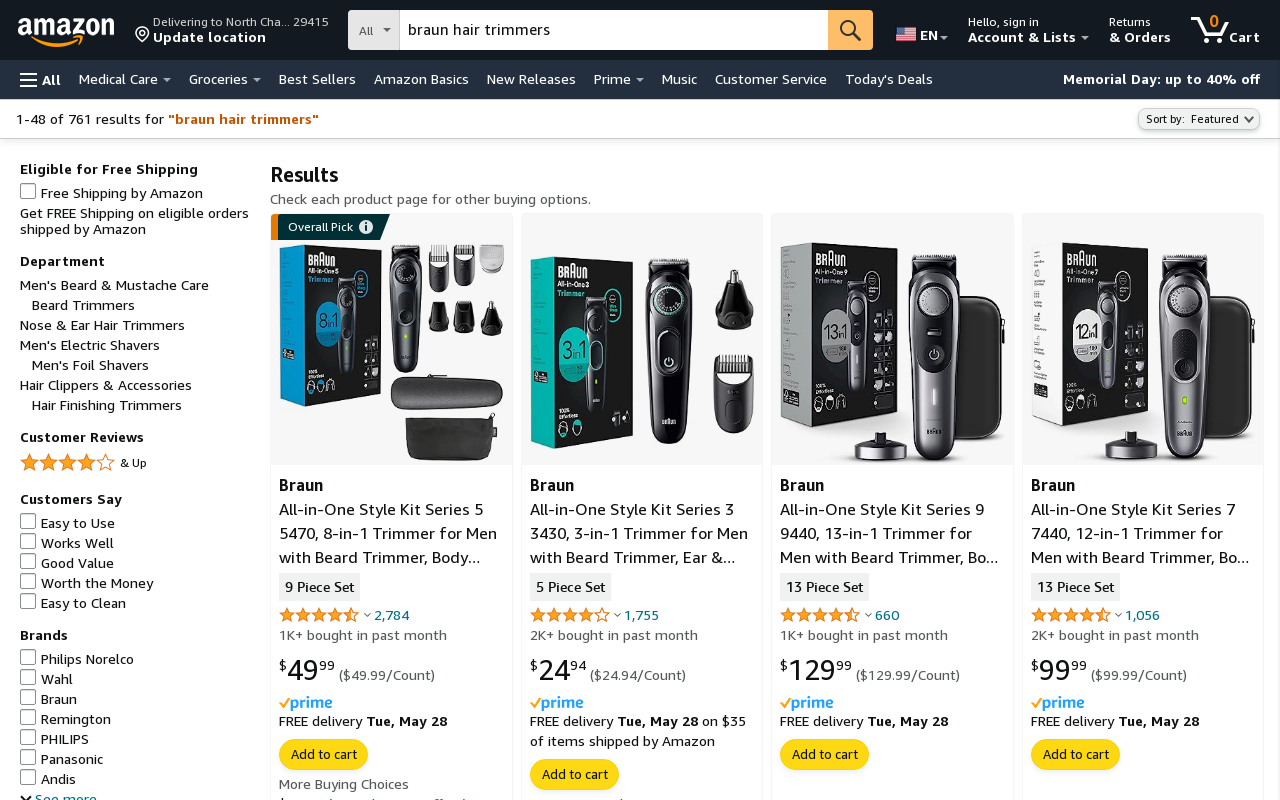

In [22]:
image_url = "/content/screenshots/6851ec9b-6ade-4ada-a848-c33ceed049a0.png"

Image(image_url)

In [25]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": """This is a screenshot of product listing on Amazon.com.
               List the products featured in this image in the order in
               which they appear from left to right. Include the price of each
               product after the name of the product. Do not make up anything.""",
        },
        {
            "type": "image_url",
            "image_url": image_url
        },
    ]
)
resp = llm.invoke([message])
print(resp.content)

- Braun All-in-One Style Kit Series 5 5470, 8-in-1 Trimmer for Men with Beard Trimmer, Body... 9 Piece Set $49.99
- Braun All-in-One Style Kit Series 3 3430, 3-in-1 Trimmer for Men with Beard Trimmer, Ear &... 5 Piece Set $24.94
- Braun All-in-One Style Kit Series 9 9440, 13-in-1 Trimmer for Men with Beard Trimmer, Bo... 13 Piece Set $129.99
- Braun All-in-One Style Kit Series 7 7440, 12-in-1 Trimmer for Men with Beard Trimmer, Bo... 13 Piece Set $99.99
